## Using Quantity sold column to group products

<b>Problem Definition</b>:
Build a model to order supplies of a given product based on the time of year. <br>
<br>
<b>Planned Goals</b>: Group products based on the unsupervised method using quantity column.<br>
<br>
<b>Achieved Goals</b>: We can group product based on this feature.<br>
<br>
<b>To-Do(s)</b>: To create a pipeline so new time series can be infrenced. <br>
<br>
<b>Contributors</b>: Kayhan B (Nov 2021)<br>
<br>
<b>Reviewers</b>: -<br>
<br>

<b>General Information</b>:<br>
- Please read the README for python virtual environment. <br>
- Use data-exploration.ipynb before this notebook.
<br>

In [7]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesResampler, TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset

import lib.helper_pandas as hp



In [2]:
%%time
# @formatter:on

df = pd.read_parquet(path = './data/retail-transaction-clean-v1.parquet', engine = 'pyarrow')
n_rows = len(df.index)
n_cols = len(df.columns)
print(f"Dataframe length is: {len(df.index)}")
print(f"Number of columns is: {len(df.columns)}")

display(df.dtypes)
hp.unique_col_percent(df = df)
hp.null_val_summary(df = df)
df.head()



Dataframe length is: 528901
Number of columns is: 12


InvoiceNo                string
StockCode                string
Description              string
Quantity                  int64
InvoiceDate      datetime64[ns]
UnitPrice               float64
CustomerID                int64
Country                  string
InvoiceNoNum              int64
StockCodeNum              int64
StockCodeChar            string
TotalPrice              float64
dtype: object

InvoiceNo unique count and percentage: 20513, 3.88
StockCode unique count and percentage: 3805, 0.72
Description unique count and percentage: 4039, 0.76
Quantity unique count and percentage: 390, 0.07
InvoiceDate unique count and percentage: 18877, 3.57
UnitPrice unique count and percentage: 901, 0.17
CustomerID unique count and percentage: 4336, 0.82
Country unique count and percentage: 38, 0.01
InvoiceNoNum unique count and percentage: 20513, 3.88
StockCodeNum unique count and percentage: 3289, 0.62
StockCodeChar unique count and percentage: 28, 0.01
TotalPrice unique count and percentage: 4865, 0.92


InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         string    string      string    int64  datetime64[ns]   
null values (nb)         0         0           0        0               0   
null values (%)        0.0       0.0         0.0      0.0             0.0   

                 UnitPrice CustomerID Country InvoiceNoNum StockCodeNum  \
column type        float64      int64  string        int64        int64   
null values (nb)         0          0       0            0            0   
null values (%)        0.0        0.0     0.0          0.0          0.0   

                 StockCodeChar TotalPrice  
column type             string    float64  
null values (nb)             0          0  
null values (%)            0.0        0.0

Wall time: 1.41 s


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123a   white hanging heart t-light holder         6   
1    536365     71053                  white metal lantern         6   
2    536365    84406b       cream cupid hearts coat hanger         8   
3    536365    84029g  knitted union flag hot water bottle         6   
4    536365    84029e       red woolly hottie white heart.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  InvoiceNoNum  \
0 2010-12-01 08:26:00       2.55       17850  united kingdom        536365   
1 2010-12-01 08:26:00       3.39       17850  united kingdom        536365   
2 2010-12-01 08:26:00       2.75       17850  united kingdom        536365   
3 2010-12-01 08:26:00       3.39       17850  united kingdom        536365   
4 2010-12-01 08:26:00       3.39       17850  united kingdom        536365   

   StockCodeNum StockCodeChar  TotalPrice  
0         85123             a       15.30  
1         71053                     20.34  
2         84406             b       22.00  
3         84029             g       20.34  
4         84029             e       20.34

In [3]:
%%time
# @formatter:on

res = {}
general_ts = pd.DataFrame(index = pd.date_range(df['InvoiceDate'].min(), df['InvoiceDate'].max(),
                                                freq = 'D',
                                                normalize = True))

for product_id, df_product in tqdm(df.groupby(['StockCodeNum'])):

    l = []
    for t in general_ts.index:
        l.append(df_product.loc[(df_product['InvoiceDate'] >= t - pd.Timedelta(days = 4)) &
                                (df_product['InvoiceDate'] <= t + pd.Timedelta(days = 4))]['Quantity'].mean())
    res[str(product_id)] = l

general_ts = pd.DataFrame(index = general_ts.index, data = res)
general_ts = general_ts.fillna(0)
general_ts.to_parquet(path = './data/product-quantity-aggregated-center-4D4D.parquet', engine = 'pyarrow')
# x=pd.read_parquet(path = './data/product-quantity-aggregated-center-4D4D.parquet', engine = 'pyarrow')



100%|██████████| 3289/3289 [17:57<00:00,  3.05it/s]


Wall time: 17min 57s


Wall time: 547 ms


<AxesSubplot:xlabel='InvoiceDate', ylabel='Quantity'>

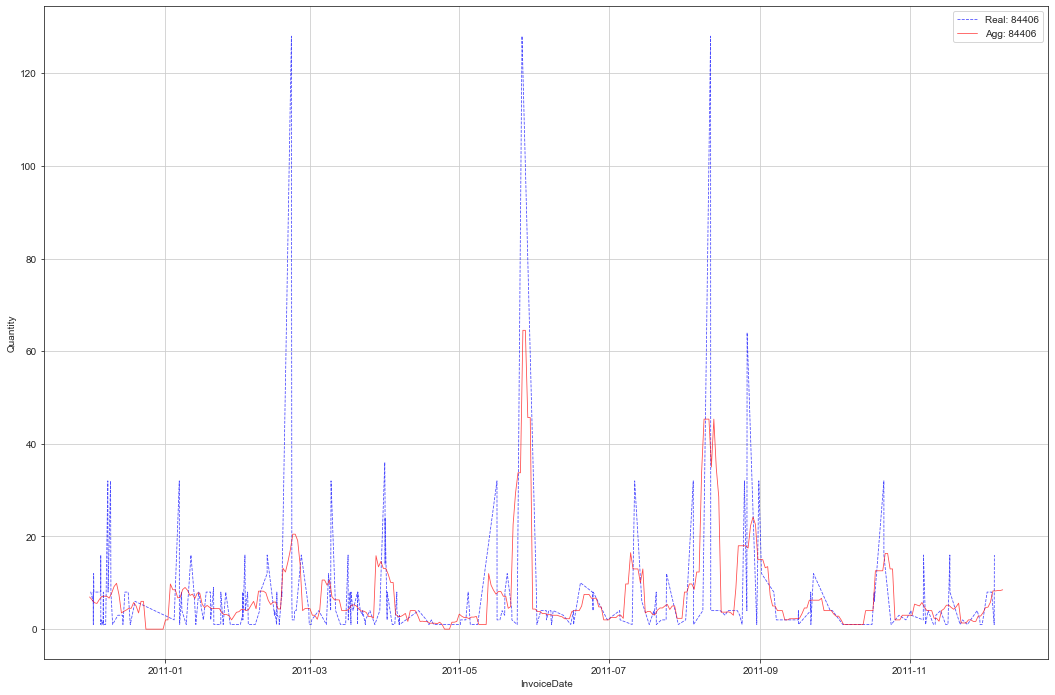

In [3]:
%%time
# @formatter:on

#general_ts = pd.read_parquet(path = './data/product-quantity-aggregated-center-4D4D.parquet', engine = 'pyarrow')
pr = 84406
plt.figure(figsize = (18, 12), )
sns.set_style("ticks", {'axes.grid': True})
sns.lineplot(x = df[df['StockCodeNum'] == pr]['InvoiceDate'],
             y = df[df['StockCodeNum'] == pr]['Quantity'],
             linestyle = '--',
             linewidth = 0.8,
             label = f"Real: {pr}",
             color = 'blue',
             alpha = 0.7)

sns.lineplot(x = general_ts.index,
             y = general_ts[str(pr)],
             linestyle = '-',
             linewidth = 0.8,
             label = f"Agg: {pr}",
             color = 'red',
             alpha = 0.7)

142.142 --> 93.660 --> 90.876 --> 89.433 --> 88.746 --> 88.412 --> 88.290 --> 88.219 --> 88.179 --> 88.150 --> 88.125 --> 88.112 --> 88.102 --> 88.093 --> 88.089 --> 88.083 --> 88.079 --> 88.079 --> 88.078 --> 88.078 --> 


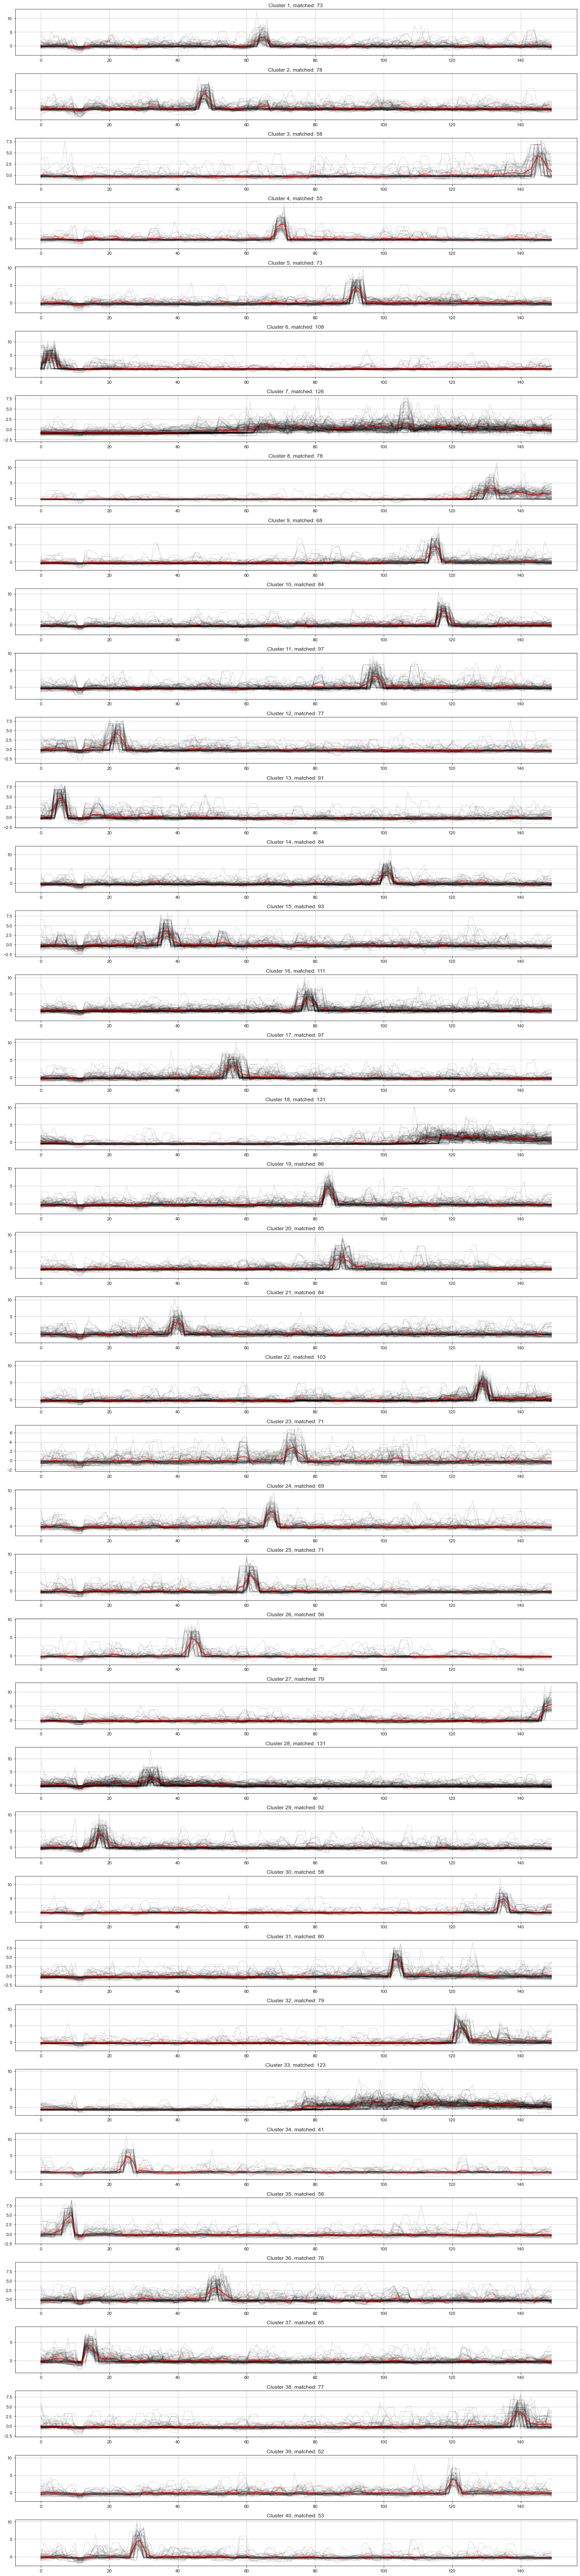

InvoiceNo StockCode                         Description  Quantity  \
24        536367     21754            home building block word         3   
33        536370     21724     panda and bunnies sticker sheet        12   
106       536381     21672  white spot red ceramic drawer knob         6   
177       536387     22779           wooden owls light garland       192   
181       536388     21754            home building block word         3   
...          ...       ...                                 ...       ...   
528370    581498     21942               skulls design flannel         1   
528400    581498     22179             set 10 night owl lights         1   
528408    581498     21987          pack of 6 skull paper cups         2   
528557    581501     23151           zinc sweetheart soap dish        12   
528740    581571     23167       small ceramic top storage jar        96   

               InvoiceDate  UnitPrice  CustomerID         Country  \
24     2010-12-01 08:34:00       5.95       13047  united kingdom   
33     2010-12-01 08:45:00       0.85       12583          france   
106    2010-12-01 09:41:00       1.25       15311  united kingdom   
177    2010-12-01 09:58:00       3.37       16029  united kingdom   
181    2010-12-01 09:59:00       5.95       16250  united kingdom   
...                    ...        ...         ...             ...   
528370 2011-12-09 10:26:00       1.63          -1  united kingdom   
528400 2011-12-09 10:26:00      13.29          -1  united kingdom   
528408 2011-12-09 10:26:00       1.63          -1  united kingdom   
528557 2011-12-09 10:46:00       0.79       12985  united kingdom   
528740 2011-12-09 12:00:00       0.69       15311  united kingdom   

        InvoiceNoNum  StockCodeNum StockCodeChar  TotalPrice  ClusterId  
24            536367         21754                     17.85        0.0  
33            536370         21724                     10.20        0.0  
106           536381         21672                      7.50        0.0  
177           536387         22779                    647.04        0.0  
181           536388         21754                     17.85        0.0  
...              ...           ...           ...         ...        ...  
528370        581498         21942                      1.63        0.0  
528400        581498         22179                     13.29        0.0  
528408        581498         21987                      3.26        0.0  
528557        581501         23151                      9.48        0.0  
528740        581571         23167                     66.24        0.0  

[9778 rows x 13 columns]

InvoiceNo StockCode                          Description  Quantity  \
3         536365    84029g  knitted union flag hot water bottle         6   
4         536365    84029e       red woolly hottie white heart.         6   
12        536367     22748            poppy's playhouse kitchen         6   
25        536369     21756             bath building block word         3   
37        536370     21913       vintage seaside jigsaw puzzles        12   
...          ...       ...                                  ...       ...   
528645    581538     21668       red stripe ceramic drawer knob         1   
528646    581538     21673  white spot blue ceramic drawer knob         1   
528670    581538    84519a      tomato charlie+lola coaster set         1   
528682    581538    84519b      carrot charlie+lola coaster set         1   
528733    581571     23182       toilet sign occupied or vacant         1   

               InvoiceDate  UnitPrice  CustomerID         Country  \
3      2010-12-01 08:26:00       3.39       17850  united kingdom   
4      2010-12-01 08:26:00       3.39       17850  united kingdom   
12     2010-12-01 08:34:00       2.10       13047  united kingdom   
25     2010-12-01 08:35:00       5.95       13047  united kingdom   
37     2010-12-01 08:45:00       3.75       12583          france   
...                    ...        ...         ...             ...   
528645 2011-12-09 11:34:00       1.45       14446  united kingdom   
528646 2011-12-09 11:34:00       1.45       14446  united kingdom   
528670 2011-12-09 11:34:00       1.25       14446  united kingdom   
528682 2011-12-09 11:34:00       1.25       14446  united kingdom   
528733 2011-12-09 12:00:00       0.83       15311  united kingdom   

        InvoiceNoNum  StockCodeNum StockCodeChar  TotalPrice  ClusterId  
3             536365         84029             g       20.34       20.0  
4             536365         84029             e       20.34       20.0  
12            536367         22748                     12.60       20.0  
25            536369         21756                     17.85       20.0  
37            536370         21913                     45.00       20.0  
...              ...           ...           ...         ...        ...  
528645        581538         21668                      1.45       20.0  
528646        581538         21673                      1.45       20.0  
528670        581538         84519             a        1.25       20.0  
528682        581538         84519             b        1.25       20.0  
528733        581571         23182                      0.83       20.0  

[17296 rows x 13 columns]

InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type         string    string      string    int64  datetime64[ns]   
null values (nb)         0         0           0        0               0   
null values (%)        0.0       0.0         0.0      0.0             0.0   

                 UnitPrice CustomerID Country InvoiceNoNum StockCodeNum  \
column type        float64      int64  string        int64        int64   
null values (nb)         0          0       0            0            0   
null values (%)        0.0        0.0     0.0          0.0          0.0   

                 StockCodeChar TotalPrice ClusterId  
column type             string    float64   float64  
null values (nb)             0          0         0  
null values (%)            0.0        0.0       0.0

Wall time: 30.2 s


In [19]:
%%time
# @formatter:on

n_clusters = 40
reduced_ts_size = 150
metric = "euclidean"  # "euclidean", "dtw", "softdtw"
ts_numpy = general_ts.to_numpy()
#ts_numpy = ts_numpy[:, :100]

ts_numpy = formatted_dataset = to_time_series_dataset(ts_numpy.T)
ts_numpy = TimeSeriesScalerMeanVariance().fit_transform(ts_numpy)
ts_numpy = TimeSeriesResampler(sz = reduced_ts_size).fit_transform(ts_numpy)

model = TimeSeriesKMeans(n_clusters = n_clusters,
                         metric = metric,
                         max_iter = 50,
                         n_jobs = 2,
                         verbose = 1,
                         random_state = 42)

y_pred = model.fit_predict(ts_numpy)
model.to_pickle(path = f'./model/timeseries-kmeans-clustered-{metric}-v1.pkl')
fig, axs = plt.subplots(n_clusters, figsize = (18, n_clusters * 2))

for yi in range(n_clusters):

    for ts in ts_numpy[y_pred == yi]:
        axs[yi].plot(ts.ravel(), "k-", alpha = 0.1)
    axs[yi].plot(model.cluster_centers_[yi].ravel(), "r-")
    axs[yi].title.set_text(f"Cluster {yi + 1}, matched: {ts_numpy[y_pred == yi].shape[0]} ")

plt.tight_layout()
plt.show()

columns = list(general_ts.columns)
for inx, cluster in enumerate(y_pred):
    df.loc[df[df['StockCodeNum'] == int(columns[inx])].index, 'ClusterId'] = int(cluster)

for cluster_id, df_cluster in df.groupby(['ClusterId']):
    if cluster_id % 20 == 0:
        display(df_cluster)

df.to_parquet(path = './data/transaction-clustered-timeseries-v1.parquet', engine = 'pyarrow')
hp.null_val_summary(df = df)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 3289 out of 3289 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 1246 

32.277 --> 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 9796 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done 11246 tasks      | elapsed:  

23.888 --> 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 9796 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 11246 tasks      | elapsed:  

23.164 --> 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done 9796 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 11246 tasks      | elapsed:  

22.838 --> 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 9796 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done 11246 tasks      | elapsed:  

22.660 --> 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 9796 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 11246 tasks      | elapsed:  

22.534 --> 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 9796 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 11246 tasks      | elapsed:  

22.437 --> 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 9796 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done 11246 tasks      | elapsed:  

22.383 --> 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 9796 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 11246 tasks      | elapsed:  

22.326 --> 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 9796 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done 11246 tasks      | elapsed:  

22.280 --> 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 9796 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done 11246 tasks      | elapsed:  

22.235 --> 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 9796 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done 11246 tasks      | elapsed:  

22.209 --> 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 9796 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done 11246 tasks      | elapsed:  

22.196 --> 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done 9796 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 11246 tasks      | elapsed:  

22.174 --> 

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 9796 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done 11246 tasks      | elapsed:  

22.159 --> 


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done 9796 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 11246 tasks      | elapsed:  

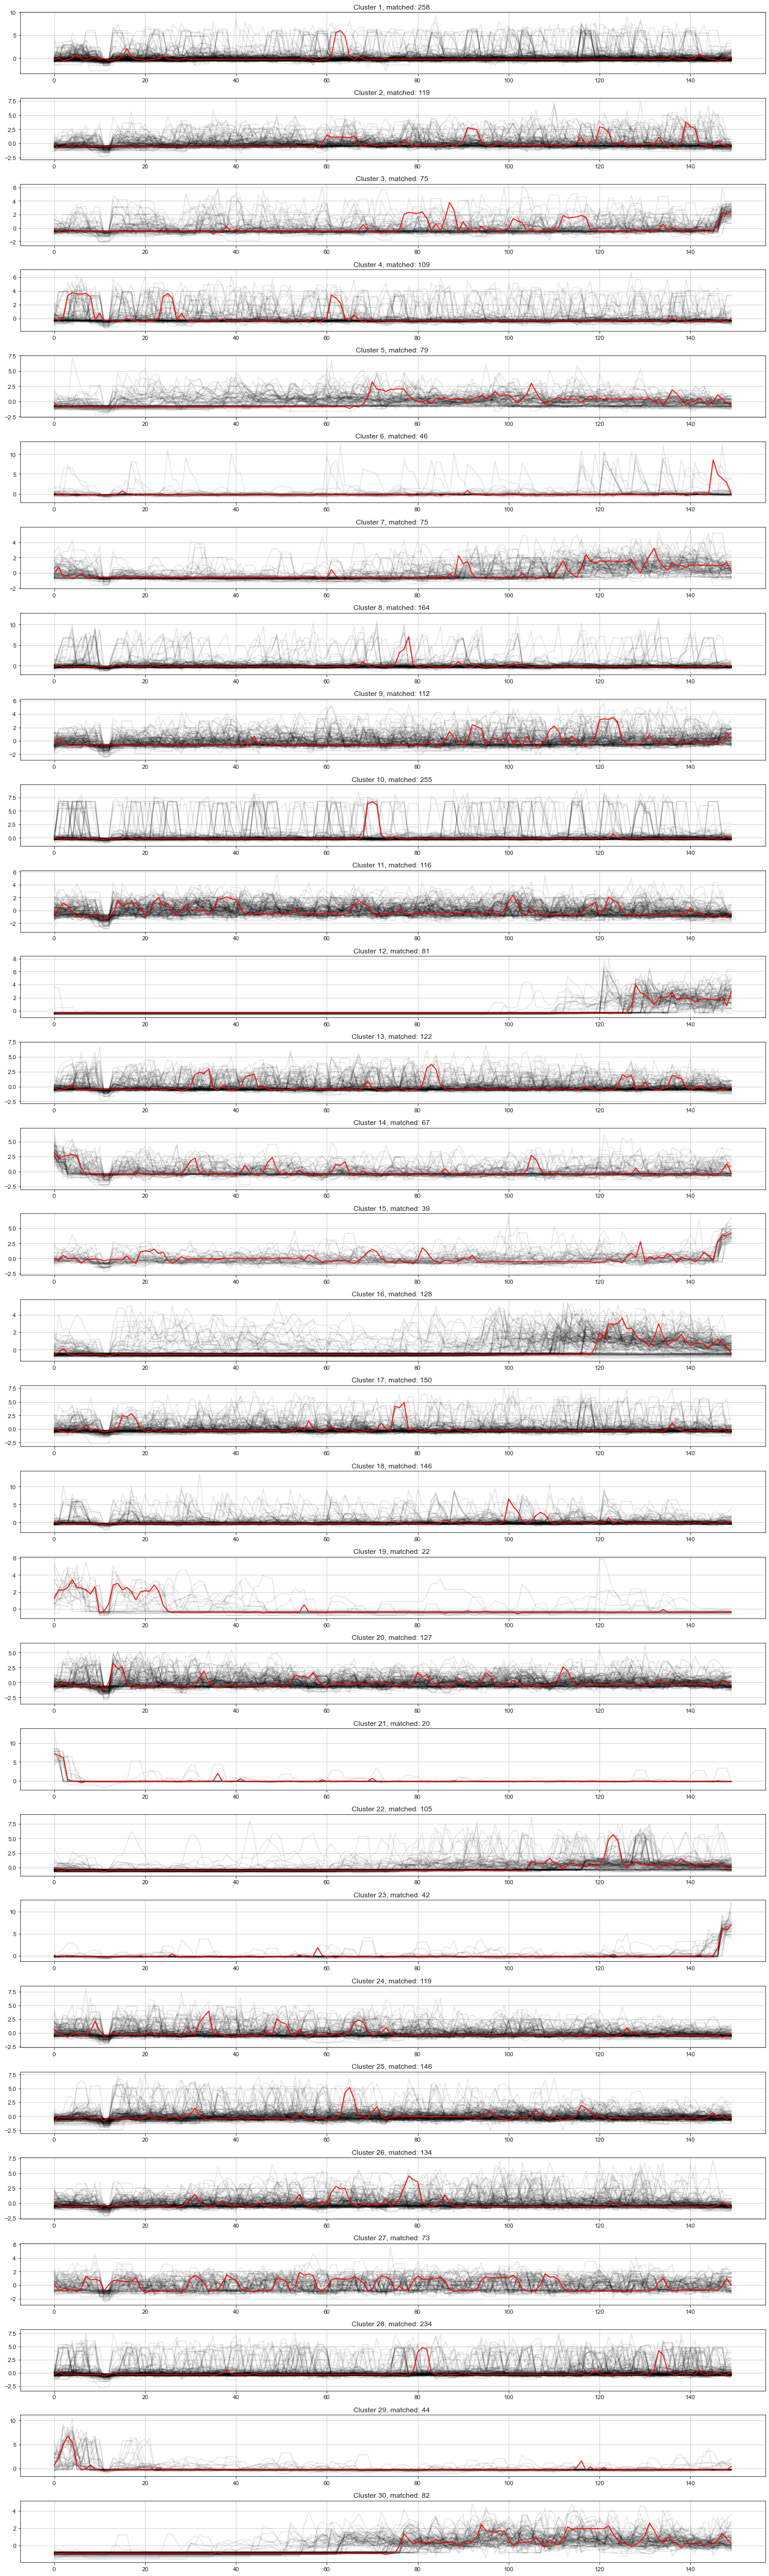

Wall time: 12min 30s


In [14]:
%%time
# @formatter:on

n_clusters = 30
reduced_ts_size = 150
metric = "dtw"  # "euclidean", "dtw", "softdtw"
ts_numpy = general_ts.to_numpy()
#ts_numpy = ts_numpy[:, :100]

ts_numpy = formatted_dataset = to_time_series_dataset(ts_numpy.T)
ts_numpy = TimeSeriesScalerMeanVariance().fit_transform(ts_numpy)
ts_numpy = TimeSeriesResampler(sz = reduced_ts_size).fit_transform(ts_numpy)

model = TimeSeriesKMeans(n_clusters = n_clusters,
                         metric = metric,
                         max_iter = 15,
                         n_jobs = 2,
                         verbose = 0,
                         random_state = 42)

y_pred = model.fit_predict(ts_numpy)
model.to_pickle(path = f'./model/timeseries-kmeans-clustered-{metric}-v1.pkl')
fig, axs = plt.subplots(n_clusters, figsize = (18, n_clusters * 2))

for yi in range(n_clusters):

    for ts in ts_numpy[y_pred == yi]:
        axs[yi].plot(ts.ravel(), "k-", alpha = 0.1)
    axs[yi].plot(model.cluster_centers_[yi].ravel(), "r-")
    axs[yi].title.set_text(f"Cluster {yi + 1}, matched: {ts_numpy[y_pred == yi].shape[0]} ")

plt.tight_layout()
plt.show()



In [20]:
%%time
# @formatter:on


df['StockCodeNumQuantitySum'] = df.groupby('StockCodeNum')['Quantity'].transform(sum)
df['StockCodeNumTotalPriceSum'] = df.groupby('StockCodeNum')['TotalPrice'].transform(sum)

# top product seller
display(df.sort_values(by = ['StockCodeNumQuantitySum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(10))
display(df.sort_values(by = ['StockCodeNumTotalPriceSum'], ascending = False).drop_duplicates(subset = ['StockCodeNum']).head(10))



InvoiceNo StockCode                         Description  Quantity  \
527427    581483     23843         paper craft , little birdie     80995   
443262    575602    85099f                jumbo bag strawberry         2   
217522    556481     23166      medium ceramic top storage jar         3   
396486    571844     22197                      popcorn holder        24   
14044     537489     84077   world war 2 gliders asstd designs        48   
506555    580136    85123a  white hanging heart t-light holder         6   
127562    547511     84879       assorted colour bird ornament         8   
160491    550673     21212     pack of 72 retrospot cake cases        24   
224284    557132     23084                  rabbit night light        12   
273486    561507     22492              mini paint set vintage        36   

               InvoiceDate  UnitPrice  CustomerID         Country  \
527427 2011-12-09 09:15:00       2.08       16446  united kingdom   
443262 2011-11-10 12:27:00       2.08       17059  united kingdom   
217522 2011-06-12 13:00:00       1.25       16115  united kingdom   
396486 2011-10-19 12:30:00       0.85       17101  united kingdom   
14044  2010-12-07 11:33:00       0.29       17017  united kingdom   
506555 2011-12-01 19:42:00       2.95       17841  united kingdom   
127562 2011-03-23 13:44:00       1.69       17411  united kingdom   
160491 2011-04-20 10:28:00       0.55       12971  united kingdom   
224284 2011-06-17 08:57:00       2.08       13107  united kingdom   
273486 2011-07-27 14:21:00       0.65       12397         belgium   

        InvoiceNoNum  StockCodeNum StockCodeChar  TotalPrice  ClusterId  \
527427        581483         23843                 168469.60       26.0   
443262        575602         85099             f        4.16       36.0   
217522        556481         23166                      3.75       28.0   
396486        571844         22197                     20.40        3.0   
14044         537489         84077                     13.92       33.0   
506555        580136         85123             a       17.70       28.0   
127562        547511         84879                     13.52       10.0   
160491        550673         21212                     13.20       34.0   
224284        557132         23084                     24.96        6.0   
273486        561507         22492                     23.40       36.0   

        StockCodeNumQuantitySum  StockCodeNumTotalPriceSum  
527427                    80995              168469.600000  
443262                    79823              155556.869231  
217522                    78033               81700.920000  
396486                    56921               51354.020000  
14044                     55047               13841.850000  
506555                    41956              124017.697778  
127562                    36461               59094.930000  
160491                    36419               21259.100000  
224284                    31722               70012.943333  
273486                    26633               16937.820000

InvoiceNo StockCode                         Description  Quantity  \
352175    568346     22423            regency cakestand 3 tier         1   
527427    581483     23843         paper craft , little birdie     80995   
121591    546986    85099f                jumbo bag strawberry        10   
174387    552262    85123a  white hanging heart t-light holder         6   
199860    554756     47566                       party bunting         8   
475473    577772     23166      medium ceramic top storage jar        48   
495577    579188     23084                  rabbit night light        18   
418972    573576    84997a    childrens cutlery polkadot green         1   
481095    578225     22086      paper chain kit 50's christmas         6   
24663     538361     22502          picnic basket wicker small         2   

               InvoiceDate  UnitPrice  CustomerID         Country  \
352175 2011-09-26 15:28:00      24.96       14096  united kingdom   
527427 2011-12-09 09:15:00       2.08       16446  united kingdom   
121591 2011-03-18 12:56:00       1.95       14194  united kingdom   
174387 2011-05-08 11:37:00       2.95       14911            eire   
199860 2011-05-26 11:36:00       4.95       16837  united kingdom   
475473 2011-11-21 15:53:00       1.04       18139  united kingdom   
495577 2011-11-28 15:34:00       2.08       12748  united kingdom   
418972 2011-10-31 14:09:00       8.29       14096  united kingdom   
481095 2011-11-23 11:51:00       2.95       17700  united kingdom   
24663  2010-12-10 16:36:00       5.95       17757  united kingdom   

        InvoiceNoNum  StockCodeNum StockCodeChar  TotalPrice  ClusterId  \
352175        568346         22423                     24.96        5.0   
527427        581483         23843                 168469.60       26.0   
121591        546986         85099             f       19.50       36.0   
174387        552262         85123             a       17.70       28.0   
199860        554756         47566                     39.60        3.0   
475473        577772         23166                     49.92       28.0   
495577        579188         23084                     37.44        6.0   
418972        573576         84997             a        8.29       36.0   
481095        578225         22086                     17.70       18.0   
24663         538361         22502                     11.90       20.0   

        StockCodeNumQuantitySum  StockCodeNumTotalPriceSum  
352175                    13890              174653.125556  
527427                    80995              168469.600000  
121591                    79823              155556.869231  
174387                    41956              124017.697778  
199860                    22180              122142.144000  
475473                    78033               81700.920000  
495577                    31722               70012.943333  
418972                    16749               69181.420000  
481095                    19355               64952.290000  
24663                      2048               60861.770000

Wall time: 1.48 s


In [21]:
%%time
# @formatter:on

df['ClusterIdQuantitySum'] = df.groupby('ClusterId')['Quantity'].transform(sum)
df['ClusterIdTotalPriceSum'] = df.groupby('ClusterId')['TotalPrice'].transform(sum)

# top cluster seller
display(df.sort_values(by = ['ClusterIdQuantitySum'], ascending = False).drop_duplicates(subset = ['ClusterId']).head(10))
display(df.sort_values(by = ['ClusterIdTotalPriceSum'], ascending = False).drop_duplicates(subset = ['ClusterId']).head(10))



InvoiceNo StockCode                        Description  Quantity  \
208475    555564     23204        charlotte bag apples design        10   
172769    552064     22361  glass jar daisy fresh cotton wool         8   
422993    574029     22142        christmas craft white fairy        12   
42635     540099     22191             ivory diner wall clock         1   
472311    577531     22079          ribbon reel hearts design         1   
390798    571433     23373   vintage christmas paper gift bag        20   
6276      536938     21479       white skull hot water bottle        72   
272441    561367     20724        red retrospot charlotte bag        19   
201055    554938     22355          charlotte bag suki design        20   
305729    564543     23211     red rocking horse hand painted        24   

               InvoiceDate  UnitPrice  CustomerID         Country  \
208475 2011-06-05 15:01:00       0.85       15005  united kingdom   
172769 2011-05-06 11:05:00       2.95       15874  united kingdom   
422993 2011-11-02 12:34:00       1.45       12955  united kingdom   
42635  2011-01-04 16:41:00       8.50       15808  united kingdom   
472311 2011-11-20 13:58:00       2.46          -1  united kingdom   
390798 2011-10-17 13:19:00       0.82       13015  united kingdom   
6276   2010-12-03 12:05:00       3.39       14680  united kingdom   
272441 2011-07-26 15:46:00       2.46          -1  united kingdom   
201055 2011-05-27 13:34:00       0.85       12876         belgium   
305729 2011-08-25 15:49:00       1.25       16818  united kingdom   

        InvoiceNoNum  StockCodeNum StockCodeChar  TotalPrice  ClusterId  \
208475        555564         23204                      8.50        6.0   
172769        552064         22361                     23.60       28.0   
422993        574029         22142                     17.40       32.0   
42635         540099         22191                      8.50       10.0   
472311        577531         22079                      2.46       36.0   
390798        571433         23373                     16.40       17.0   
6276          536938         21479                    244.08       13.0   
272441        561367         20724                     46.74        1.0   
201055        554938         22355                     17.00       27.0   
305729        564543         23211                     30.00       15.0   

        StockCodeNumQuantitySum  StockCodeNumTotalPriceSum  \
208475                     7976                 7741.94000   
172769                      733                 2615.43000   
422993                     3264                 4987.78000   
42635                      1452                11971.15000   
472311                     1911                 3348.39000   
390798                     1608                 1313.39000   
6276                       4671                25522.83500   
272441                    17771                21789.84750   
201055                    18153                29280.12625   
305729                     2331                 2933.07000   

        ClusterIdQuantitySum  ClusterIdTotalPriceSum  
208475                374729           738931.261071  
172769                288074           592914.589384  
422993                278468           408178.488333  
42635                 275365           470192.641261  
472311                235266           462430.897231  
390798                233109           332698.169440  
6276                  227383           379277.292333  
272441                192260           266405.929595  
201055                186990           286411.134083  
305729                175711           271334.461500

InvoiceNo StockCode                        Description  Quantity  \
396837    571883     23148  miniature antique rose hook ivory         6   
228272    557503     22628    picnic boxes set of 3 retrospot         4   
114472    546387     22961             jam making set printed        24   
3831      536732     21244                blue polkadot plate         8   
274846    561635     23092    large antique white photo frame         2   
357666    568831     23323                  white wicker star         3   
376737    570244     22603      christmas retrospot tree wood        14   
179640    552687    84519b    carrot charlie+lola coaster set         2   
471083    577493     21329             dinosaurs  writing set         3   
335534    567043     23389             spaceboy mini backpack         2   

               InvoiceDate  UnitPrice  CustomerID         Country  \
396837 2011-10-19 13:58:00       0.83       14704  united kingdom   
228272 2011-06-20 15:47:00       4.95       16839  united kingdom   
114472 2011-03-11 13:34:00       1.45       16766  united kingdom   
3831   2010-12-02 12:47:00       1.69       15544  united kingdom   
274846 2011-07-28 14:35:00       7.90       16912  united kingdom   
357666 2011-09-29 11:35:00       2.10       16059  united kingdom   
376737 2011-10-09 16:05:00       0.85       14514  united kingdom   
179640 2011-05-10 15:09:00       5.79          -1  united kingdom   
471083 2011-11-20 12:13:00       1.65       17323  united kingdom   
335534 2011-09-16 11:27:00       4.15       13268  united kingdom   

        InvoiceNoNum  StockCodeNum StockCodeChar  TotalPrice  ClusterId  \
396837        571883         23148                      4.98        6.0   
228272        557503         22628                     19.80       28.0   
114472        546387         22961                     34.80       10.0   
3831          536732         21244                     13.52       36.0   
274846        561635         23092                     15.80        9.0   
357666        568831         23323                      6.30       32.0   
376737        570244         22603                     11.90       13.0   
179640        552687         84519             b       11.58       20.0   
471083        577493         21329                      4.95       18.0   
335534        567043         23389                      8.30       17.0   

        StockCodeNumQuantitySum  StockCodeNumTotalPriceSum  \
396837                     2144                    1820.46   
228272                      966                    4625.86   
114472                    16412                   25660.98   
3831                       2287                    3801.62   
274846                      525                    3773.58   
357666                     1473                    3155.18   
376737                     1389                    1237.08   
179640                      984                    1680.10   
471083                      944                    1728.64   
335534                     1122                    4780.54   

        ClusterIdQuantitySum  ClusterIdTotalPriceSum  
396837                374729           738931.261071  
228272                288074           592914.589384  
114472                275365           470192.641261  
3831                  235266           462430.897231  
274846                153369           439618.158643  
357666                278468           408178.488333  
376737                227383           379277.292333  
179640                155506           373032.630845  
471083                175684           364638.756746  
335534                233109           332698.169440

Wall time: 1.23 s


In [ ]:
%%time
# @formatter:on

